In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

In [2]:
def event_happens(occurrence_probability):
    """ An event happens if a randomly chosen number
        falls bellow the given occurrence probability """
    return np.random.rand() < occurrence_probability

In [3]:
def lognormal_event_result(lower, upper):
    """ Draws a number from the lognormal distribution
        with given lower and upper bounds for confidence interval """
    mean = (np.log(upper) + np.log(lower))/2.0
    stdv = (np.log(upper) - np.log(lower))/3.29
    return np.random.lognormal(mean,stdv)

In [4]:
events_basic = pd.read_csv('events.csv')
events_basic.head()

,Vulnerability,Probability,Lower,Upper
0,User impersonation,0.15,100000,5000000
1,Stored XSS,0.04,5000000,25000000
2,SQL Injection,0.05,1000000,10000000
3,Reversed weak passwords,0.11,2000000,20000000
4,Insecure DOR,0.10,400000,2500000


In [5]:
def simulate_scenario(events):
    """ If an event from the input list happens, add the losses due to it """
    total_loss = 0
    for _, event in events.iterrows():
        if event_happens(event['Probability']):
            total_loss += lognormal_event_result(event['Lower'],event['Upper'])
    return total_loss

simulate_scenario(events_basic)

5618287.392976769

In [6]:
def monte_carlo(events, rounds):
    """ Simulate many scenarios, returns the results as simple List """
    list_losses = []
    for i in range(rounds):
        loss_result = simulate_scenario(events)
        list_losses.append(loss_result)
    return list_losses

# To test Monte Carlo execution time for some number of iterations      
import time
start_time = time.time()
monte_carlo(events_basic, 1000)
print(time.time() - start_time)

1.0723190307617188


In [7]:
# This time run for real, save the results as pandas Series and as numpy parray
results = monte_carlo(events_basic, 1000)
results_series = pd.Series(results)
results_nparray = np.array(results)
results_series.describe()
results_nparray

array([ 2758612.55735579,  8184697.64964241,   351680.12231139,
        2090531.60236463, 13485772.34679997,  3527956.86802254,
        7909262.87288446,  4124305.70071225,  6362950.93735167,
        5800336.30037515,  2096263.08893927,  5486229.11379152,
        8411706.62130688, 10517830.36015031,  6528585.04073629,
       16302360.20941953,  3792587.86654055,  8816300.9397434 ,
        3988167.56724811,  3904023.32920281,  5622171.39314122,
        1887819.29345176,  7923588.76118439, 19311324.72534232,
        3564998.77719385,  1143922.2062964 , 21039429.77376304,
        6584341.36060268,  8888703.89688407,  1574362.59420552,
        4010127.64479875, 13546533.53565639, 28786151.14257842,
       11924699.48909633,  7000658.14269648,  1719907.78902995,
        9242535.29814469,  9227004.74003298,  4708847.20901575,
        4134600.27843113,  2067974.48125417,  1464699.83297675,
        2652477.73193719,  4601855.50344582,  6176978.61346933,
        7830515.63205353, 61539636.68780

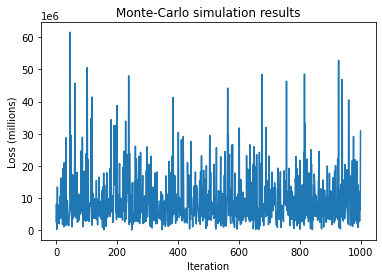

In [8]:
# Plot the results in the order they came out
results_series.plot()
plt.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
plt.xlabel('Iteration')
plt.ylabel('Loss (millions)')
plt.title('Monte-Carlo simulation results')
plt.savefig('results-raw.png')

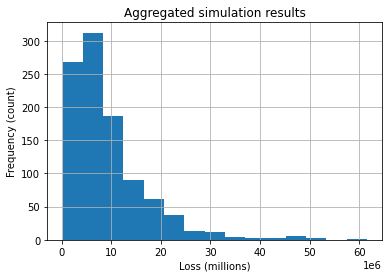

In [9]:
# Aggregate and plot them as a histogram
results_series.hist(bins=15)
plt.xlabel('Loss (millions)')
plt.ylabel('Frequency (count)')
plt.ticklabel_format(axis='x',style='sci',scilimits=(6,6))
plt.title('Aggregated simulation results')
plt.savefig('results-hist.png')

In [10]:
def plot_lec(results_nparray, label):
    """ Plots the loss exceedance curve from
        an nparray of Monte Carlo results """
    hist, edges = np.histogram(results_nparray, bins=40)
    cumrev = np.cumsum(hist[::-1]*100/len(results_nparray))[::-1]
    plt.plot(edges[:-1], cumrev, label=label)
    plt.xlabel('Loss (millions)')
    plt.ylabel('Chance of loss or greater (%)')
    plt.ticklabel_format(axis='x',style='sci',scilimits=(6,6))
    plt.title('Loss Exceedance Curve')
    plt.grid()
    #plt.xscale('log')

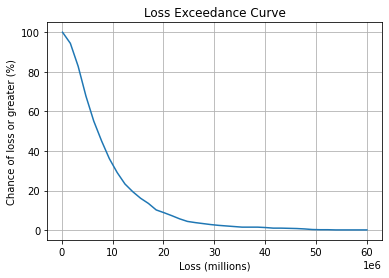

In [11]:
plot_lec(results_nparray, 'Inherent risk')
plt.savefig('lec-simple.png')

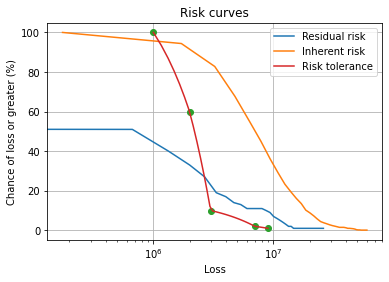

In [13]:
# Obtain the residual risk curve
events_redux = pd.read_csv('events_redux.csv')
results_redux = monte_carlo(events_redux, 100)

arr_redux = np.array(results_redux)
plot_lec(arr_redux, 'Residual risk')
plot_lec(results_nparray, 'Inherent risk')
plt.xscale('log')
plt.xlabel('Loss')
plt.grid()

# Interpolate the risk tolerance curve
xs = np.array([1,2,3,7,9])*(1e6)
tols = np.array([100,60,10,2,1])

plt.plot(xs, tols, 'o')
xint = np.linspace(min(xs), max(xs))
yint = interpolate.interp1d(xs, tols, kind='slinear')
plt.plot(xint, yint(xint), label='Risk tolerance')
plt.xscale('log')
plt.legend()
plt.title('Risk curves')
plt.savefig('risk-curves-together.png')

In [14]:
def get_vars(array):
    """ Computes the 5% VaR and tVar from an nparray of Monte Carlo results """
    var  = np.percentile(array, 95)
    tvar = np.average(array[array >= var])
    return var, tvar

In [15]:
def gen_random_events():
    """ Simulates read input data """
    probability_column = np.random.random_sample(30)*0.1
    lower_ci_column    = np.random.random_sample(30)*(1e6)
    upper_ci_column    = np.random.random_sample(30)*(9e6)+1e6
    dicc = {'Probability' : probability_column,
            'Lower' : lower_ci_column,
            'Upper': upper_ci_column}
    events_rand = pd.DataFrame(dicc)
    return events_rand

gen_random_events().head()

,Probability,Lower,Upper
0,0.023340,828950.935538,3.002238e+06
1,0.099694,877085.834557,9.816950e+06
2,0.013392,999404.188450,6.377941e+06
3,0.032605,24018.363870,2.850080e+06
4,0.029876,900273.592947,5.377419e+06


In [16]:
def simulate_daily_vars(num_days):
    """ Runs Monte-Carlo over a number of days with simulated inputs """
    vars, tvars = [], []
    for i in range(num_days):
        events = gen_random_events()
        results = monte_carlo(events, 100)
        results_nparray = np.array(results)
        var, tvar = get_vars(results_nparray)
        vars.append(var)
        tvars.append(tvar)
    return vars, tvars

In [17]:
# Simulate t/Var monitoring
days = 30
vars, tvars = simulate_daily_vars(days)
t = np.arange(1, days + 1)

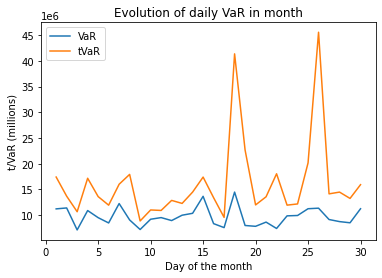

In [18]:
plt.plot(t, vars, label='VaR')
plt.plot(t, tvars, label='tVaR')
plt.title('Evolution of daily VaR in month')
plt.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
plt.ylabel('t/VaR (millions)')
plt.xlabel('Day of the month')
plt.legend()
plt.savefig('monitor-var-time.png')